# Parition function of classical 2D stat-mech model

2D Ferromagnetic Ising model

    H = -\sum_{\langle ij \rangle} \sigma_i \sigma_j

Partition function - sum of Boltzman weights for all configurations

    Z(\beta) = \sum_{\mathbf{\sigma}} exp(-\Beta H) = \sum_{\mathbf{\sigma}} \prod_{\langle ij \rangle} exp(\Beta \sigma_i \sigma_j)
    
Partition function = contraction of a tensor network

    x--h--x--h--x--h--x
    |     |     |     |
    h     h     h     h
    |     |     |     |
    x--h--x--h--x--h--x
    |     |     |     |
    h     h     h     h
    |     |     |     |
    x--h--x--h--x--h--x
    
where rank-2 tensor h<=>exp(\Beta \sigma_i \sigma_j) is a Boltzman weight located on the edge between two neighbouring Ising spins ij 
and x<=>\delta_{uldr} is a rank-4 tensor enforcing the same Ising spin state to enter the Boltzman weights on the adjacent edges.

By writing out h=\sqrt(h)\sqrt(h), i.e. as two weights with temperature \Beta/2, on each edge and absorbing these weights symmetrically
into x's on each vertex we get familiar PEPS form

                |
              \sqrt(h)   
                |                 |
    --\sqrt(h)--x--\sqrt(h)-- = --A--
                |                 |
             \sqrt(h)
                |

The partition function Z(A(\beta)) is given by the contraction

    A--A--A
    A--A--A
    A--A--A

In [6]:
# import numpy as np
import numpy as np
import scipy.linalg

transpose= np.transpose
einsum=np.einsum
argsort= lambda x: np.argsort(x)[::-1]
diag= np.diag
eigvalsh= np.linalg.eigvalsh

## i) On-site tensor

Define on-site tensor A that generates the PEPS corresponding to partition function Z

In [3]:
sigma= np.asarray([1,-1])
x= np.zeros((2,2,2,2))
x[0,0,0,0]=x[1,1,1,1]=1

def f_sqrth(beta):
    r"""
    Square root of rank-2 Boltzman weight from Ising interaction
    """
    return scipy.linalg.sqrtm(np.exp(beta*np.tensordot(sigma,sigma,([],[]))).reshape(sigma.shape*2))
    
def f_A(beta):
    r"""
    On-site tensor A generating the partition function Z(\Beta)
    """
    h= f_sqrth(beta)
    return np.einsum('ux,ly,dz,rw,xyzw->uldr',h,h,h,h,x)

### i.1) Check symmetries of A

Convince yourself, that tensor A obeys point-group symmetries of square lattice.

A_uldr = A_ldru rotation by pi/2 clockwise

A_uldr = A_ruld rotation by pi/2 anti-clockwise

A_uldr = A_dlur reflection along x-axis

A_uldr = A_urdl reflection along y-axis

In [31]:
print(np.linalg.norm(A-transpose(A,(1,2,3,0))))
print(np.linalg.norm(A-transpose(A,(3,0,1,2))))
print(np.linalg.norm(A-transpose(A,(2,1,0,3))))
print(np.linalg.norm(A-transpose(A,(0,3,2,1))))

2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16
2.220446049250313e-16


## ii) Build initial CTM boundary 

Consider two options for initial boundary

Option a): Initial C,T are created from Boltzman weights on the open-boundary edges 
              
    C-- = x--\sqrt(h)
    |     |
          \sqrt(h) 
        
    --T-- = \sqrt(h)--x--\sqrt(h)
      |               | 
                     \sqrt(h)
                     
Option b): Take random (symmetric) C,T

In [17]:
def init_obc_CT(beta,chi):
    r"""
    Build initial boundaries from Boltzman weights of open boundary system
    """
    h=f_sqrth(beta)
    x_C= np.eye(2)
    C=np.zeros((chi,chi))
    C[:2,:2]=np.einsum('dx,ry,xy->dr',h,h,x_C)
    
    x_T= np.zeros((2,2,2))
    x_T[0,0,0]=x_T[1,1,1]=1
    T=np.zeros((chi,chi,2))
    T[:2,:2,:]=np.einsum('lx,dy,rz,xyz->lrd',h,h,h,x_T)
    return C,T

def init_rand_CT(A,chi):
    r"""
    Build random initial boundaries C, T
    """
    C=np.random.rand(chi,chi)
    C=C+transpose(C,(1,0))
    T=np.random.rand(chi,chi,2)
    T=T+transpose(T,(1,0,2))
    return C,T

## iii) The CTMRG move

First, enlarge the system

    C_i--T_i--C_i      C_i--T_i--T_i--T_i--C_i
    T_i--A----T_i  =>  T_i--A----A----A----C_i
    C_i--T_i--C_i      T_i--A----A----A----C_i
                       T_i--A----A----A----C_i
                       C_i--T_i--T_i--T_i--C_i

### iii.1) Expand
Define and accumulate enlarged quadrant of the system into enlarged corner tensor
of size (\chi*D)^2

    C_i--T_i-- = C'_i==
    |    |       ||
    T_i--A----
    |    |
    
Afterwards, compute its optimal compression up to rank \chi and retrieve corresponding projectors

    C'== =  U'--D'--U'^\dag==  => compress =>  U--\chi--D--\chi--U^\dag==    
    ||      ||                                 ||

In [18]:
def enlarged_C(A,C,T):
    r"""
    Build enlarged corner tensor
    
        C----1 1(0)---T--2(1) = C'==2,7
        0             3(2)      ||
        0(1)          3(0)      4,6
        T--5(2) 5(1)--A--7(3)
        4(0)          6(2) 
    """
    return einsum(C,(0,1),T,(1,2,3),T,(4,0,5),A,(3,5,6,7),(4,6,2,7))

def compress(chi,C):
    r"""
    Compute optimal projectors U, which compress C' to at most rank-\chi corner tensor C
    """
    D,U= np.linalg.eigh(C.reshape(C.shape[0]*C.shape[1],C.shape[2]*C.shape[3]))
    
    # reorder by magnitude
    ind=argsort(np.abs(D))
    D= D[ind[:chi]]
    U= U[:,ind[:chi]].reshape(C.shape[0],C.shape[1],chi)
    return D,U

### iii.2) Absorb

Renormalize the network, be absorbing and compressing enlarged corners and half-row/-column transfer matrices

    C_i--T_i--T_i--T_i--C_i      C_{i+1}--T_{i+1}--C_{i+1}     
    T_i--A----A----A----C_i  =>  T_{i+1}--A--------T_{i+1}
    T_i--A----A----A----C_i      C_{i+1}--T_{i+1}--C_{i+1} 
    T_i--A----A----A----C_i
    C_i--T_i--T_i--T_i--C_i

Using optimal projectors, extend half-row/-column transfer matrix and compress it

                                     |
                                     U
    |    |     ||                    ||       |
    T_i--A-- = T'_i-- => compress => T'_i-- = T_{i+1}
    |    |     ||                    ||       |
                                     U^\dag
                                     |

In [19]:
def absorb(A,T,U):
    r"""
    Aborb and compress half-row/-column tensor given optimal projector of enlarged corner
    
        4(2)
        U
        |---------\   
        1(0)       3(1)
        1          3(0)      1
        T--2 2(1)--A--6(3) = T--2
        0          5(2)      0
        0          5(1)
        |----------/
        U^\dag
        7(2)
    """
    return einsum(T,(0,1,2),U,(1,3,4),A,(3,2,5,6),U.conj(),(0,5,7),(7,4,6))

### iii.3) Compose enlarge, compress, and absorb operations into a full CTM move

The compressed corner is given by leading-chi kept eigenvalues C_{i+1} of enlarged corner

In [20]:
def ctm_iter(A,C,T,chi):
    r"""
    Performs a single CTM interation renormalizing the boundary tensors
    to environment dimension \chi
    """
    D,U= compress(chi, enlarged_C(A,C,T))
    C_n= diag(D)
    T_n= absorb(A,T,U)
    return C_n,T_n

## iv) CTMRG algorithm

The CTMRG algorithm requires an initial choice of the boundary tensors.
Afterwards, it is iterated until the fixed point is reached.

* Normalize numerical values of the boundary tensors by making magnitude of the largest element equal to 1.
* To establish convergence, let's use spectra of the corners.

In [21]:
def ctmrg(A,C,T,chi,ctm_max_iter=100,ctm_conv_tol=1.0e-8,callback=None):
    r"""
    Return a fixed point of CTMRG process for PEPS generated by tensor A with initial boundaries C,T
    """
    # setup
    # spectrum of initial corner
    s_i= eigvalsh(C)
    inds=argsort(s_i)
    s_i=s_i[inds]/abs(s_i).max()
    
    # main ctmrg loop
    for i in range(ctm_max_iter):
        C,T= ctm_iter(A,C,T,chi)
        
        # normalize numerical values of boundary tensors by making magnitude of largest element equal to 1
        # and symmetrize T tensor (suppres finite-precision error)
        C= C/abs(C).max()
        T= T+transpose(T,(1,0,2))
        T= T/abs(T).max()
        
        # check convergence
        inds=argsort(diag(C))
        conv_crit= abs(diag(C)[inds]-s_i).sum()
        
        # (optional) monitor through callback
        if callback: callback(i,conv_crit,(conv_crit < ctm_conv_tol) or i==ctm_max_iter-1,A,C,T)
        if conv_crit < ctm_conv_tol: break
        s_i= diag(C)[inds]
        
    return C,T

## v) Evaluate on-site observable: magnetization

Thermal expectation value of magnetization is given as

    m = \langle \sigma \rangle = Tr[\sigma exp(-\Beta H)] / Z(\Beta)
    
which can be reinterpreted as a ratio of two tensor networks, which we approximate
through converged boundary tensors
          
              ...              ...
           A--A--A     /  ..A--A--A..          CTC   / CTC
    m = ...A--B--A..  /   ..A--A--A.. \approx  TBT  /  TAT
           A--A--A   /    ..A--A--A            CTC /   CTC
              ...              ...
          
where tensor B carries an on-site observable, \sigma         

In [22]:
def f_B(beta):
    r"""
    On-site tensor B carrying, obtained from A by modifying the weights with observable \sigma
    """
    h= f_sqrth(beta)
    return np.einsum('ux,ly,dz,rw,xyzw,x->uldr',h,h,h,h,x,sigma)

def aux_rho_1x1(C,T):
    r"""
    Build environment of single site
    
        i) C--1 1(0)--T--2(1) = C--T--1
           0          3(2)      0  2

        ii) C--T--1 1(0)--C   = C--T-----C
            0  2          |     0  2  3--T
                    4(2)--T              1
                          3(1)

        iii) C------T-------C
             0      2       |
             0(1)           |
             T---4(3)    3--T
             |              1
             |      5(2)    1(0)
             C------T-------C       
    """
    rho=einsum(C,(0,1),T,(1,2,3),(0,2,3))
    rho=einsum(rho,(0,1,2),rho,(1,3,4),(0,3,2,4))
    rho=einsum(rho,(0,1,2,3),rho,(1,0,5,4),(2,4,5,3))
    return rho

def eval_1x1(B,A,rho):
    r"""
    Given 1x1 environment rho, compute the normalized expectation value 
    of on-site tensor B
    """
    return einsum('uldr,uldr',rho,B)/einsum('uldr,uldr',rho,A)

## vi) Wrap everything up to compute phase diagram

The exact solution gives critical temperature and magnetization profile

    \Beta_c = log(1 + \sqrt(2))/2
    
    m=(1-[sinh(2\Beta)]^{-4})^{1/8}
    
Pick environment dimension \chi and compute magnetization profile for a range of \Beta

(Tip: use randomly initialized environments. What happens if you instead use one generated from Boltzman weights ?) 


In [23]:
chi=8

betas=np.linspace(0.1,0.6,20)
ms=[]
spec_C=[]

for beta in betas:
    A= f_A(beta)
    C,T= ctmrg(A,*init_rand_CT(beta,chi),chi,ctm_max_iter=1000,ctm_conv_tol=1.0e-8,
               callback=(lambda i,conv_crit,conv,_A,_C,_T: print(f"{beta} {i} {conv_crit} {_C.diagonal()}") if conv else None))
    
    m= eval_1x1(f_B(beta),A,aux_rho_1x1(C,T))
    
    ms.append(m)

0.1 5 4.1493204267269526e-09 [1.00000000e+00 1.00688694e-01 1.02080344e-03 1.02783365e-04
 1.03490755e-05 1.04203490e-06 1.04841546e-07 1.05643715e-08]
0.12631578947368421 6 3.294287387087398e-09 [1.00000000e+00 1.27731677e-01 2.08399100e-03 2.66191665e-04
 3.40010636e-05 4.34301287e-06 5.54630431e-07 7.08578986e-08]
0.15263157894736842 7 3.3757772915070786e-09 [1.00000000e+00 1.55192947e-01 3.73779897e-03 5.80080037e-04
 9.00242753e-05 1.39711325e-05 2.16802005e-06 3.36492408e-07]
0.17894736842105263 8 3.1478212175819675e-09 [1.00000000e+00 1.83203700e-01 6.14897496e-03 1.12651497e-03
 2.06381651e-04 3.78098803e-05 6.92635230e-06 1.26903256e-06]
0.20526315789473684 9 6.199447014899569e-09 [1.00000000e+00 2.11928222e-01 9.51845325e-03 2.01722887e-03
 4.27507563e-04 9.06008974e-05 1.91978688e-05 4.06918093e-06]
0.23157894736842105 11 2.2507321259296244e-09 [1.00000000e+00 2.41579446e-01 1.40987283e-02 3.40596298e-03
 8.22810504e-04 1.98773912e-04 4.80050899e-05 1.16003592e-05]
0.2578947

/tmp/ipykernel_15752/227043601.py:6: RuntimeWarning: invalid value encountered in power
  ax[0].plot(np.linspace(np.min(betas),np.max(betas),100), np.nan_to_num((1-np.sinh(2*np.asarray(np.linspace(np.min(betas),np.max(betas),100)))**(-4))**(1/8)),color="black")
/tmp/ipykernel_15752/227043601.py:7: RuntimeWarning: invalid value encountered in power
  ax[1].scatter(betas, abs(np.asarray(ms))-np.nan_to_num((1-np.sinh(2*np.asarray(betas))**(-4))**(1/8)) )


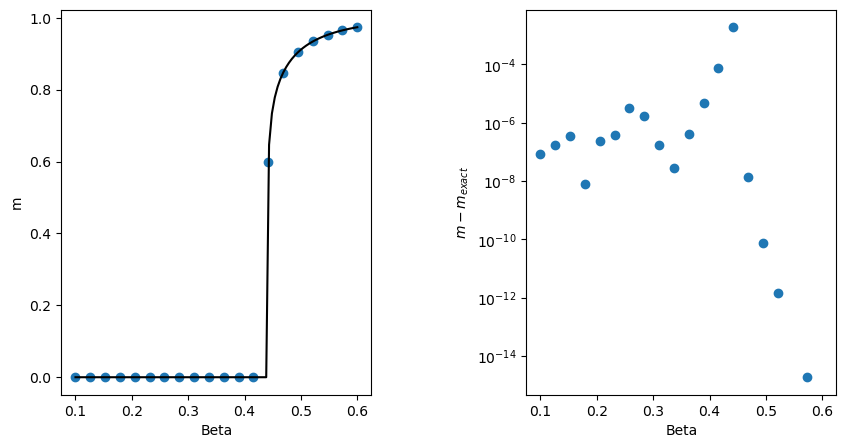

In [24]:
import matplotlib.pyplot as plt

# plot
fig, ax = plt.subplots(1,2,figsize=(10, 5),gridspec_kw={'wspace': 0.5})
ax[0].scatter(betas, abs(np.asarray(ms)))
ax[0].plot(np.linspace(np.min(betas),np.max(betas),100), np.nan_to_num((1-np.sinh(2*np.asarray(np.linspace(np.min(betas),np.max(betas),100)))**(-4))**(1/8)),color="black")
ax[1].scatter(betas, abs(np.asarray(ms))-np.nan_to_num((1-np.sinh(2*np.asarray(betas))**(-4))**(1/8)) )

ax[0].set_xlabel(r"Beta")
ax[0].set_ylabel(r"m")

ax[1].set_xlabel(r"Beta")
ax[1].set_ylabel(r"$m-m_{exact}$")
ax[1].set_yscale('log')

plt.show()

## vii) What about correlation lengths ?

Compute PEPS correlation length from the leading part of the spectrum of widht-1 PEPS transfer matrix

    --T--
    --A-- = \sum_i \lambda_i |v_i><v_i|
    --T--

In [25]:
from scipy.sparse.linalg import LinearOperator, eigs

def xi(A,T,n=2,v0=None):
    r"""
    Compute leading n-eigenvalues of width-1 transfer operator
    
    Use dominant eigensolver supplying a matrix-vector operation
    
      --0(chi) 0-----T--3(1)     ---0
     |               4(2)       |
     |               4(0)       |
     v--1(D) 1(1)----A---6(3) = v'--1
     |               5(2)       |
     |               5(2)       |
      --2(chi) 2(1)--T--7(0)     ---2
    """
    def _mv(v):
        v= v.reshape(T.shape[0],A.shape[1],T.shape[1])
        v= np.einsum(v,(0,1,2),T,(0,3,4),A,(4,1,5,6),T,(7,2,5),(3,6,7))
        v= v.reshape(T.shape[0]*A.shape[1]*T.shape[1])
        return v

    Tw1= LinearOperator((T.shape[0]*A.shape[1]*T.shape[1],)*2, matvec=_mv)
    vals= eigs(Tw1, k=n, v0=v0, return_eigenvectors=False)

    # post-process
    ind_sorted= np.argsort(np.abs(vals))[::-1] # descending order
    vals= vals[ind_sorted]
    vals= (1.0/np.abs(vals[0])) * vals
    
    return -1./np.log(np.abs(vals[1])), vals

In [26]:
chi=16

betas=np.linspace(0.1,0.6,20)
ms=[]
xis=[]

for beta in betas:
    A= f_A(beta)
    C,T= ctmrg(A,*init_rand_CT(beta,chi),chi,ctm_max_iter=1000,ctm_conv_tol=1.0e-8,
               callback=(lambda i,conv_crit,conv,_A,_C,_T: print(f"{beta} {i} {conv_crit} {_C.diagonal()}") if conv else None))
    
    m= eval_1x1(f_B(beta),A,aux_rho_1x1(C,T))
    
    ms.append(m)
    xi_,spec= xi(A,T,n=2)
    xis.append(xi_)

0.1 5 4.260905366215172e-09 [1.00000000e+00 1.00688694e-01 1.02080344e-03 1.02783365e-04
 1.03490818e-05 1.04203553e-06 1.04850845e-07 1.05643783e-08
 1.05572946e-08 1.06371345e-09 1.02922613e-09 1.07032100e-10
 1.03631434e-10 1.07769110e-11 6.88911593e-12 2.22535817e-12]
0.12631578947368421 6 4.56062467983887e-09 [1.00000000e+00 1.27731677e-01 2.08399100e-03 2.66191665e-04
 3.40010628e-05 4.34301277e-06 5.54629212e-07 7.08579090e-08
 7.08437193e-08 9.05079953e-09 8.95722769e-09 1.15584229e-09
 1.14412171e-09 1.47637673e-10 1.23201580e-10 1.88579788e-11]
0.15263157894736842 7 5.7429578441400874e-09 [1.00000000e+00 1.55192947e-01 3.73779896e-03 5.80080036e-04
 9.00242730e-05 1.39711322e-05 2.16805344e-06 3.36492634e-07
 3.36466602e-07 5.22212835e-08 5.20240136e-08 8.10374781e-09
 8.07375980e-09 1.25764450e-09 1.17107295e-09 1.95177252e-10]
0.17894736842105263 8 8.291490116702034e-09 [1.00000000e+00 1.83203700e-01 6.14897496e-03 1.12651497e-03
 2.06381637e-04 3.78098795e-05 6.92664186e-0

/tmp/ipykernel_1195/240297457.py:6: RuntimeWarning: invalid value encountered in power
  ax[0].plot(np.linspace(np.min(betas),np.max(betas),100), np.nan_to_num((1-np.sinh(2*np.asarray(np.linspace(np.min(betas),np.max(betas),100)))**(-4))**(1/8)),color="black")
/tmp/ipykernel_1195/240297457.py:10: RuntimeWarning: invalid value encountered in power
  ax[1].scatter(betas, abs(np.asarray(ms))-np.nan_to_num((1-np.sinh(2*np.asarray(betas))**(-4))**(1/8)) )


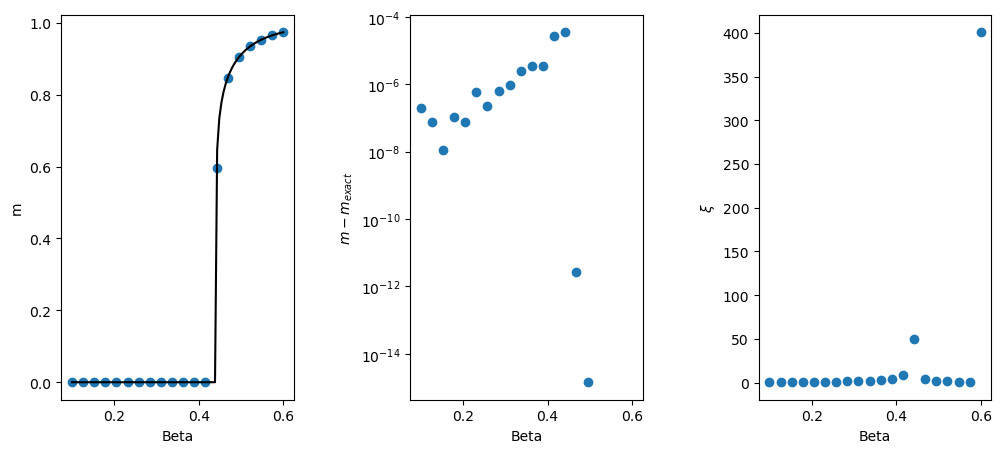

In [39]:
import matplotlib.pyplot as plt

# plot
fig, ax = plt.subplots(1,3,figsize=(12, 5),gridspec_kw={'wspace': 0.5})
ax[0].scatter(betas, abs(np.asarray(ms)))
ax[0].plot(np.linspace(np.min(betas),np.max(betas),100), np.nan_to_num((1-np.sinh(2*np.asarray(np.linspace(np.min(betas),np.max(betas),100)))**(-4))**(1/8)),color="black")
ax[0].set_xlabel(r"Beta")
ax[0].set_ylabel(r"m")

ax[1].scatter(betas, abs(np.asarray(ms))-np.nan_to_num((1-np.sinh(2*np.asarray(betas))**(-4))**(1/8)) )
ax[1].set_xlabel(r"Beta")
ax[1].set_ylabel(r"$m-m_{exact}$")
ax[1].set_yscale('log')

ax[2].scatter(betas, xis)
ax[2].set_xlabel(r"Beta")
ax[2].set_ylabel(r"$\xi$")

plt.show()

# AFM Heisenberg model

> This exercise implements a basic form of 
> https://github.com/jurajHasik/peps-torch/blob/master/examples/j1j2/optim_j1j2_c4v.py

We want to find PEPS ansatz, which minimizes the energy of **2D spin-1/2 AFM Heisenberg model on a square lattice**

    H = -\sum_{\langle ij \rangle} \mathbf{S}_i \cdot \mathbf{S}_j
    
where \mathbf{S}_i is a vector of spin-1/2 generators \mathbf{S} = (S^z,S^x,S^y)

This model characterizes antiferromagnets, arising as a strongly-interacting limit of a single-band Hubbard model
at half-filling.

Although we expect the ground state to posses Q=(pi,pi), i.e. Neel order, we can still get away with 
single-site translationally invariant PEPS ansatz. We can 

    a) obtain Q=(pi,pi) state from a ferromagnet by appropriate unitary rotation -2iS^y on each site 
       of one of the two sublattices of square lattice
     
or using complementary point of view
     
    b) transform the Hamiltonian by unitary, such that its ground state becomes 
       a translationally invariant correlated ferromagnet

We parametrize the PEPS ansatz by a single real and C4v-symmetric rank-5 tensor

       u s
       |/
    l--a--r <=> a^s_uldr with s being physical index (at position 0), followed by auxiliary indices u,l,d,r 
       |                 one for each edge of site
       d
       
We want this tensor to transform trivially (as an A_1 irrep) under the action of square lattice point group (C_{4v}), i.e.
    
    * rotations by pi/2 clock-wise and counter-clockwise
    * vertical and horizontal reflections

## 0) preliminary

Custom "vjp" for eigendecomposition, i.e., 

Symmetric eigendecomposition is a (non-linear) function from A \in Matrices_{NxN} -> (D \in R^{N},U \in Matrices_{NxN})

Given an A_0, and a differentials (dD, dU) belonging to the same spaces as outputs (D,U) compute 
the vector-matrix product of differentials (dD, dU) here reshaped into a vector and a Jacobian of the eigendecompostion evaluated at A_0

(dD, dU) . \frac{\partial eigendecompostion}{\partial (A)}|_{A_0} = dA

resulting in the differential dA \in Matrices_{NxN}.  

Why?
This function object defines how to compute derivatives of eigenvalue decomposition. 
The automatic differentiation engine (in this case PyTorch's autograd) will use this
definition, which regularizes derivative in case of degenerate eigenvalues, when
computing gradient of objective function.

In [10]:
import torch
torch.set_default_dtype(torch.float64)

einsum= torch.einsum
diag= torch.diag
transpose= torch.permute
eigvalsh= torch.linalg.eigvalsh
argsort= lambda x: torch.sort(x, dim=- 1, descending=True, stable=False, out=None)[1]

class SYMEIG(torch.autograd.Function):
    @staticmethod
    def forward(self, A):
        r"""
        :param A: square symmetric matrix
        :type A: torch.Tensor
        :return: eigenvalues values D, eigenvectors vectors U
        :rtype: torch.Tensor, torch.Tensor

        Computes symmetric decomposition :math:`M= UDU^\dagger`.
        """
        # is input validation (A is square and symmetric) provided by torch.linalg.eigh ?

        D, U = torch.linalg.eigh(A)
        # torch.symeig returns eigenpairs ordered in the ascending order with 
        # respect to eigenvalues. Reorder the eigenpairs by abs value of the eigenvalues
        # abs(D)
        absD,p= torch.sort(torch.abs(D),descending=True)
        D= D[p]
        U= U[:,p]

        self.save_for_backward(D,U)
        return D,U

    @staticmethod
    def backward(self, dD, dU):
        r"""
        :param dD: gradient on D
        :type dD: torch.Tensor
        :param dU: gradient on U
        :type dU: torch.Tensor
        :return: gradient
        :rtype: torch.Tensor

        Computes backward gradient for ED of symmetric matrix with regularization
        of :math:`F_{ij}=1/(D_i - D_j)`
        """
        epsilon=1.0e-12
        D, U= self.saved_tensors
        Uh = U.t().conj()
        D_scale= D[0].abs() # D is ordered in descending fashion by abs val

        F = (D - D[:, None])
        F = F/(F**2 + epsilon)
        F.diagonal().fill_(0)
        
        dA = U @ (torch.diag(dD) + F*(Uh@dU)) @ Uh
        return dA

## i) build initial CTM boundary

Consider two options:
    
    * a) by partial contraction of on-site tensor and it's adjoint
    * b) a simple random "product state-like" boundary with environment dimension \chi=1

In [11]:
def init_pbc_CT(a,chi):
    r"""
    Build initial boundaries from on-site tensor

            u           
        l--a*--y   = C--1
          /\         0
         x  m
             \ u
           l--a--r
             /
            d
        
            x      =   1     
        l--a*--z       T--2
          /\           0
         y  m
             \ u
           l--a--r
             /
            d
    """
    C=torch.zeros((chi,chi))
    C[:a.shape[3]**2,:a.shape[4]**2]=torch.einsum('suldr,sulxy->dxry',a,a.conj()).reshape(a.shape[2]**2,a.shape[3]**2)
    
    T=torch.zeros((chi,chi,a.shape[4]**2))
    T[:a.shape[1]**2,:a.shape[3]**2,:]=torch.einsum('suldr,sxlyz->dylxrz',a,a.conj()).reshape(a.shape[2]**2,a.shape[3]**2,a.shape[4]**2)
    
    return C,T

def init_random_product_CT(a,chi):
    r"""
    Build initial boundaries as trivial C and random T
    """
    C=torch.zeros((chi,chi))
    C[0,0]=1.
    
    T=torch.zeros((chi,chi,a.shape[4]**2))
    T[0,0,:]= torch.rand(a.shape[4]**2)
    return C,T

## ii) redefine CTMRG 

Using the components from 2D Ising, define CTMRG process now 

    * utilizing regularized eigendecompostion SYMEIG as D,U= SYMEIG.apply(M)
 
    * renormalizing double-layer networks 

In [35]:
def dl_aadag(a):
    return einsum('suldr,sxyzw->uxlydzrw',a,a.conj()).reshape([a.shape[1]**2,]*4)

def compress(chi,C):
    r"""
    Compute optimal projectors U, which compress C' to at most rank-\chi corner tensor C
    """
    D,U= SYMEIG.apply(C.reshape(C.shape[0]*C.shape[1],C.shape[2]*C.shape[3]))
    
    # reorder by magnitude
    ind=argsort(abs(D))
    D= D[ind[:chi]]
    U= U[:,ind[:chi]].reshape(C.shape[0],C.shape[1],chi)
    return D,U

def ctmrg_dl(a,C,T,chi,**kwargs):
    A= dl_aadag(a)
    return ctmrg(A,C,T,chi,**kwargs)

## iii) Test CTMRG procedure

Benchmark your implementation against optimized PEPS
(see https://github.com/jurajHasik/j1j2_ipeps_states)

1. clone the repo with dataset containing optimized PEPS states for J1-J2 model
2. load on-site tensor and build double-layer tensor
3. run CTMRG until convergence

In [ ]:
! git clone https://github.com/jurajHasik/j1j2_ipeps_states.git

In [13]:
import os,sys
if not any(['j1j2_ipeps_states' in path for path in sys.path]):
    sys.path.insert(1, os.path.join(os.getcwd(), 'j1j2_ipeps_states'))
    
from ipeps_io import load_from_pepstorch_json_dense

a= torch.asarray(load_from_pepstorch_json_dense("j1j2_ipeps_states/single-site_pg-C4v-A1/j20.0/state_1s_A1_j20.0_D3_chi_opt108.json"))

chi=18
C,T= ctmrg_dl(a,*init_random_product_CT(a,chi),chi)
print(C.diag())

# Look at spectrum of the corner. For chi=18, you should obtain following data
#
# spectrum(C)= [1.0000, -0.5220,  0.5215, -0.4195,  0.4189,  0.3171, -0.2569,  0.2569,
#        -0.2108, -0.1329,  0.1295, -0.1295, -0.1285,  0.1282,  0.1096, -0.0842,
#         0.0842,  0.0760]

tensor([ 1.0000, -0.5220,  0.5215, -0.4195,  0.4189,  0.3171, -0.2569,  0.2569,
        -0.2108, -0.1329,  0.1295, -0.1295, -0.1285,  0.1282,  0.1096, -0.0842,
         0.0842,  0.0760])


## iv) Evaluation of variational energy

Construct reduced density matrix of nearest-neighbour pair

        C--T--------------T--------------C = rho_s0s1,s'0s'1
        |  |              |              |     
        T--a[s'0]^+a[s0]--a[s'1]^+a[s1]--T   
        |  |              |              |
        C--T--------------T--------------C
        
Define exhange spin vector \mathbf{S}, interaction operator \mathbf{S}_i \cdot \mathbf{S}_j, and the unitary rotation operator -2iS^y

In [14]:
def rho_2x1(a,C,T):
    r"""
    Build reduced density matrix of nearest-neighbours
    
        i) C--1 1(0)--T--2(1) = C--T--1
           0          3(2)      0  2

        ii) C--T--1 1(0)--C   = C--T-----C
            0  2          |     0  2  3--T
                    4(2)--T              1 
                          3(1)
        
        Reshape auxiliary indices of T's and append a, a*, and last T
        
        iii) C-----------T------------------1
             |           |----\
             |           4     5
             |           4(1)  5(1)                  C--T-------0
             T---2 2(2)--a[6(0)]------------8(4)   = T--A[4,5]==2,3
             | \-3 3(2)--|-----a*[9(0)]-----11(4)    C--T-------1
             |           7(3)  10(2)
             |           7(2)  10(3)
             C--0 0(1)---T------------------12(0)
             
        iv) C--T-------0   0(1)--T-------C
            T--A[4,5]==2,3 2,3===A[6,7]--T = rho_2,6;5,7
            C--T-------1   1(0)--T-------C
    """
    rho=einsum(C,(0,1),T,(1,2,3),(0,2,3))
    rho=einsum(rho,(0,1,2),rho,(1,3,4),(0,3,2,4))
    rho=rho.reshape([C.shape[0],]*2+[a.shape[1],]*4)
    rho=einsum(rho,(0,1,2,3,4,5),a,(6,4,2,7,8),a.conj(),(9,5,3,10,11),T.reshape([C.shape[0],]*2+[a.shape[1],]*2),(12,0,7,10),(12,1,8,11,6,9))
    rho=einsum(rho,(0,1,2,3,4,5),rho,(1,0,2,3,6,7),(4,6,5,7))
    
    # symmetrize and normalize
    rho= rho.reshape([a.shape[0]**2,]*2)
    rho= rho+rho.transpose(1,0)
    rho= (rho/rho.trace()).reshape([a.shape[0]]*4)
    
    return rho

def Svec():
    return 0.5*torch.asarray([[[1,0],[0,-1]], [[0,1],[1,0]], [[0,-1j],[1j,0]]],dtype=torch.complex128)

def SS():
    return einsum('xij,xkl->ikjl',Svec(),Svec()).real

def rot_op():
    return (-1j*torch.asarray([[0,-1j],[1j,0]],dtype=torch.complex128)).real

## v) Test observables

Evaluate energy and on-site magnetization of the state

    \langle \mathbf{S}_i \cdot \mathbf{S}_j \rangle = Tr(rho_2x1 \mathbf{S}_i \cdot \mathbf{\tilde{S}}_j
                                                         
    \langle \mathbf{S} \rangle = Tr(rho_2x1 \mathbf{S}\otimes\mathbf{1})
                                                         
where \mathbf{\tilde{S}} is a vector of spin operators appropriately conjugated by unitary rot_op

In [15]:
S= Svec()
SS_op= SS()
u= rot_op()

def observables(a,C,T):
    r"""
    Given boundary tensors C,T and on-site tensor a, evaluate
    and return expectation values of NN spin exchange and components of spin vectors
    """
    rho= rho_2x1(a,C,T)
    e= einsum('ijab,xb,axiy,yj',rho,u,SS_op,u)
    m= einsum('ijaj,xai->x',rho,S.real)
    return e, m

# here we recompute environment and evaluate observables for selected state
a= torch.asarray(load_from_pepstorch_json_dense("j1j2_ipeps_states/single-site_pg-C4v-A1/j20.0/state_1s_A1_j20.0_D3_chi_opt108.json"))

chi=18
C,T= ctmrg_dl(a,*init_random_product_CT(a,chi),chi)

e,m= observables(a,C,T)
print(f"<S.S>_NN, m^z, m^x, m^y\n"+f"{e}, {m[0]}, {m[1]}, {m[2]}")

# you should find 
# <S.S>_NN, m^z, m^x, m^y
# -0.33359724591894546, -0.19644642869439194, 0.28794605609487134, 0.0

<S.S>_NN, m^z, m^x, m^y
-0.33359724593430873, -0.19644642900585768, 0.2879460559157889, 0.0


## vi) Optimization

### vi.1) Objective function

Lets create a full objective function, which takes on-site tensor a, projected to A_1 irrep
of C_{4v} group, and returns the observables as well as converged boundaries C,T

In [57]:
def make_c4v_symm_A1(a):
    r"""
    Project on-site tensor `a` on :math:`A_1` irrep of :math:`C_{4v}` group.
    """
    a= 0.5*(a + a.permute(0,1,4,3,2))   # left-right reflection
    a= 0.5*(a + a.permute(0,3,2,1,4))   # up-down reflection
    a= 0.5*(a + a.permute(0,4,1,2,3))   # pi/2 anti-clockwise
    a= 0.5*(a + a.permute(0,2,3,4,1))   # pi/2 clockwise
    return a

def obj(a):
    a= make_c4v_symm_A1(a)
    a= a/abs(a).max()
    C,T= ctmrg_dl(a,*init_random_product_CT(a,chi),chi,callback=None)
    e,m= observables(a,C,T)
    return e,m,C,T

### vi.2) Gradient descent

Starting from a random symmetric tensor, perform gradient descent optimization. 
To evalute gradients, use reverse-mode automatic differentiation provided by PyTorch.

See basics of optimization with PyTorch - see https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

Experiment with different optimizers - see https://pytorch.org/docs/stable/optim.html

Hint: As a generic non-linear optimization, you might get stuck in local minima.
Try different random seeds / initializations of tensor a.

In [ ]:
bond_dim=2
chi=16
learning_rate=1.0
max_opt_iter=100

a0= make_c4v_symm_A1(torch.rand([2,]+[bond_dim,]*4)-0.5).requires_grad_(requires_grad=True)

# optimizer= torch.optim.SGD([a0,], lr=learning_rate)
optimizer= torch.optim.LBFGS([a0,], lr=1, max_iter=1, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=100, line_search_fn=None)

def closure():
    optimizer.zero_grad()
    e,m,C,T= obj(a0)
        
    # Backpropagation
    e.backward()
    
    # report observables
    print(f"{e}, {m}, {torch.linalg.norm(a0.grad.reshape(-1))}, {torch.linalg.norm(a0.grad.reshape(-1), ord=float('inf')), {torch.linalg.norm(a0.reshape(-1),ord=float('inf'))}}")
    return e

for i in range(max_opt_iter):
    # update tensor
    optimizer.step(closure)

## vii) What about correlation lengths

We have obtained some (optimal?) PEPS approximating GS of AFM Heisenberg model.
How large are correlation lengths of such PEPS states ?

In [ ]:
a= a0.detach().clone()
chi=18
e,m,C,T= obj(a)
print(f"{e} {m}")

# C--4(1)
# 2(0) 
# 2(1)      C--0
# T--3(2) = T--1
# 1(0)      C--2  
# 1
# C--0
v0= einsum(C,(0,1),T,(1,2,3),C,(2,4),(4,3,0)).reshape(C.shape[0]*T.shape[2]*C.shape[0])
corr_l,spec_T= xi(dl_aadag(a).numpy(),T.numpy(),n=2,v0=v0.numpy())
corr_l

# Analysis of S=2 AKLT state and spin-1/2 NN RVB

    1. get peps-torch
    
    2. use AKLT S=2 example: examples/akltS2/ctmrg_akltS2_c4v.py
       (or see https://github.com/jurajHasik/peps-torch/blob/master/examples/akltS2/ctmrg_akltS2_c4v.py)
       
    3. use spin-1/2 J1-J2 example: examples/j1j2/ctmrg_j1j2_c4v.py
       (or see https://github.com/jurajHasik/peps-torch/blob/master/examples/j1j2/ctmrg_j1j2_c4v.py)

Explore spin-spin correlation functions, dimer correlation function, and spectrum of the corner or transfer matrix as a function of chi 

In [ ]:
! git clone https://github.com/jurajHasik/peps-torch.git

## i) Evaluate environment and observables of S=2 AKLT state

This example reads in the on-site tensor a of AKLT state, converges the CTMRG to obtain
environment tensors C,T and then computes various observables:
Hamiltonian term, components of magnetization, spin-spin and dimer-dimer correlation functions

This states shows a rapid decay of all correlation functions.

(https://github.com/jurajHasik/peps-torch/blob/master/examples/akltS2/ctmrg_akltS2_c4v.py)

In [51]:
# corrf_r dictates range over which correlation functions are evaluated

! cd peps-torch; python examples/akltS2/ctmrg_akltS2_c4v.py --instate test-input/AKLT-S2_1x1.in --chi 16 --corrf_r 10

/home/urza/Projects/scratch/ETN-2023/peps-torch/ipeps/tensor_io.py:8: Warning: yast not available
  warnings.warn("yast not available", Warning)
NumPy: 1.22.3
PyTorch: 1.11.0
SciPy: 1.7.3
peps-torch git ref: 3e22249
/bin/sh: 1: cd: can't cd to /home/urza/Projects/scratch/ETN-2023/peps-torch/yast
yast git ref: 3e22249
MAINARGS
bond_dim= 1
chi= 16
corrf_r= 10
instate= test-input/AKLT-S2_1x1.in
instate_noise= 0.0
ipeps_init_type= RANDOM
omp_cores= 1
opt_max_iter= 100
opt_resume= None
opt_resume_override_params= False
out_prefix= output
seed= 0
GLOBALARGS
device= cpu
dtype= float64
offload_to_gpu= None
tensor_io_format= legacy
torch_dtype= torch.float64
PEPSARGS
build_dl= True
build_dl_open= False
quasi_gauge_max_iter= 1000000
quasi_gauge_tol= 1e-08
CTMARGS
ad_decomp_reg= 1e-12
conv_check_cpu= False
ctm_absorb_normalization= inf
ctm_conv_tol= 1e-08
ctm_env_init_type= CTMRG
ctm_force_dl= False
ctm_logging= False
ctm_max_iter= 50
ctm_move_sequence= [(0, -1), (-1, 0), (0, 1), (1, 0)]
fpcm_fpt

## ii) Evaluate environment and observables of spin-1/2 NN RVB state

This example reads in the on-site tensor a of AKLT state, converges the CTMRG to obtain
environment tensors C,T and then computes various observables:
energy of J1-J2 Hamiltonina, components of magnetization, spin-spin and dimer-dimer correlation functions

This states shows a rapid decay of spin-spin correlations, but increasingly slower decay (with larger chi) of dimer-dimer correlations.

    * As chi is increased, the CTMRG starts to take larger amount of iterations to converge, easily beyond 1000
    * You can explore how variational energy behaves as frustration J2 is increased 
    
(https://github.com/jurajHasik/peps-torch/blob/master/examples/j1j2/ctmrg_j1j2_c4v.py)

In [53]:
! cd peps-torch; python examples/j1j2/ctmrg_j1j2_c4v.py --instate test-input/RVB_1x1.in --chi 18 --corrf_r 20 --top_n 10 --CTMARGS_ctm_max_iter 1000

/home/urza/Projects/scratch/ETN-2023/peps-torch/ipeps/tensor_io.py:8: Warning: yast not available
  warnings.warn("yast not available", Warning)
NumPy: 1.22.3
PyTorch: 1.11.0
SciPy: 1.7.3
peps-torch git ref: 3e22249
/bin/sh: 1: cd: can't cd to /home/urza/Projects/scratch/ETN-2023/peps-torch/yast
yast git ref: 3e22249
MAINARGS
bond_dim= 1
chi= 18
corrf_canonical= False
corrf_dd_v= False
corrf_r= 20
delta_zz= 1.0
force_cpu= False
hz_stag= 0.0
instate= test-input/RVB_1x1.in
instate_noise= 0.0
ipeps_init_type= RANDOM
j1= 1.0
j2= 0.0
j3= 0.0
obs_freq= -1
omp_cores= 1
opt_max_iter= 100
opt_resume= None
opt_resume_override_params= False
out_prefix= output
seed= 0
top2= False
top_n= 10
GLOBALARGS
device= cpu
dtype= float64
offload_to_gpu= None
tensor_io_format= legacy
torch_dtype= torch.float64
PEPSARGS
build_dl= True
build_dl_open= False
quasi_gauge_max_iter= 1000000
quasi_gauge_tol= 1e-08
CTMARGS
ad_decomp_reg= 1e-12
conv_check_cpu= False
ctm_absorb_normalization= inf
ctm_conv_tol= 1e-08
ctm

# U(1)-symmetric Simple update [peps-torch & YASTN]

## i) AFM Heisenberg model on a square lattice 

Optimize AFM Heisenberg model on a square lattice using PEPS with 2x2 unit cell
    
    1. get submodules - YASTN
    2. simulate coupled spin-1/2 ladders in isotropic Heisenberg limit using examples/ladders/abelian/SU_ladders_u1.py
       (see https://github.com/jurajHasik/peps-torch/blob/master/examples/ladders/abelian/SU_ladders_u1.py)
    
Starting from mean-field Neel state.

You can compare the energies between these D=4 optimizations and the gradient ones.

In [ ]:
! cd peps-torch; git submodule update --init --recursive

In [56]:
# alpha=1 represents (isotropic) 2D AFM Heisenberg model on a square lattice

! cd peps-torch; python examples/ladders/abelian/SU_ladders_u1.py --alpha 1. --bond_dim 4 --chi 16 --instate test-input/abelian/NEEL_D1_2x2_abelian-U1_state.json

NumPy: 1.22.3
PyTorch: 1.11.0
SciPy: 1.7.3
peps-torch git ref: 3e22249
/bin/sh: 1: cd: can't cd to /home/urza/Projects/scratch/ETN-2023/peps-torch/yast
yast git ref: 3e22249
MAINARGS
SU_adaptive_slowdown_factor= 0.5
SU_ctm_obs_freq= 0
SU_init_step= 0.1
SU_min_energy_diff= 1e-08
SU_policy= ADAPTIVE
SU_stop_cond= 1e-06
alpha= 1.0
bond_dim= 4
bz_stag= 0.0
chi= 16
instate= test-input/abelian/NEEL_D1_2x2_abelian-U1_state.json
instate_noise= 0.0
ipeps_init_type= RANDOM
omp_cores= 1
opt_max_iter= 100
opt_resume= None
opt_resume_override_params= False
out_prefix= output
seed= 0
top_freq= -1
top_n= 2
yast_backend= torch
GLOBALARGS
device= cpu
dtype= float64
offload_to_gpu= None
tensor_io_format= legacy
torch_dtype= torch.float64
PEPSARGS
build_dl= True
build_dl_open= False
quasi_gauge_max_iter= 1000000
quasi_gauge_tol= 1e-08
CTMARGS
ad_decomp_reg= 1e-12
conv_check_cpu= False
ctm_absorb_normalization= inf
ctm_conv_tol= 1e-08
ctm_env_init_type= CTMRG
ctm_force_dl= False
ctm_logging= False
ctm_max